# Evolving a Lunar Lander with differentiable Genetic Programming

## Installation
To install the required libraries run the command:

In [ ]:
!pip install -r requirements.txt

## Imports
Imports from the standard genepro-multi library are done here. Any adjustments (e.g. different operators) should be made in the notebook. For example:

```
class SmoothOperator(Node):
  def __init__(self):
    super(SmoothOperator,self).__init__()
    self.arity = 1
    self.symb = "SmoothOperator"

  def _get_args_repr(self, args):
    return self._get_typical_repr(args,'before')

  def get_output(self, X):
    c_outs = self._get_child_outputs(X)
    return np.smoothOperation(c_outs[0])

  def get_output_pt(self, X):
    c_outs = self._get_child_outputs_pt(X)
    return torch.smoothOperation(c_outs[0])
```

In [10]:
import gymnasium as gym

from genepro.node_impl import *
from genepro.evo import Evolution
from genepro.node_impl import Constant

import torch
import torch.optim as optim

import random
import os
import copy
from collections import namedtuple, deque

import matplotlib.pyplot as plt
from matplotlib import animation

from datetime import datetime
import time
import csv

## Reinforcement Learning Setup
Here we first setup the Gymnasium environment. Please see https://gymnasium.farama.org/environments/box2d/lunar_lander/ for more information on the environment. 

Then a memory buffer is made. This is a buffer in which state transitions are stored. When the buffer reaches its maximum capacity old transitions are replaced by new ones.

A frame buffer is initialised used to later store animation frames of the environment.

In [2]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def __iadd__(self, other):
      self.memory += other.memory
      return self 

    def __add__(self, other):
      self.memory = self.memory + other.memory 
      return self

In [4]:
frames = []

## Fitness Function

Here you get to be creative. The default setup evaluates 5 episodes of 300 frames. Think of what action to pick and what fitness function to use. The Multi-tree takes an input of $n \times d$ where $n$ is a batch of size 1.

In [5]:
def fitness_function_pt(multitree, num_episodes=5, episode_duration=300, render=False, ignore_done=False):
  memory = ReplayMemory(10000)
  rewards = []

  for _ in range(num_episodes):
    # get initial state of the environment
    observation = env.reset()
    observation = observation[0]
    
    for _ in range(episode_duration):
      if render:
        frames.append(env.render())

      input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      
      # what goes here? TODO
      action =  torch.argmax(multitree.get_output_pt(input_sample))
      observation, reward, terminated, truncated, info = env.step(action.item())
      rewards.append(reward)
      output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
      memory.push(input_sample, torch.tensor([[action.item()]]), output_sample, torch.tensor([reward]))
      if (terminated or truncated) and not ignore_done:
        break

  fitness = np.sum(rewards)
  
  return fitness, memory

## Evolution Setup
Here the leaf and internal nodes are defined. Think about the odds of sampling a constant in this default configurations. Also think about any operators that could be useful and add them here. 

Adjust the population size (multiple of 8 if you want to use the standard tournament selection), max generations and max tree size to taste. Be aware that each of these settings can increase the runtime.

In [6]:
num_features = env.observation_space.shape[0]
leaf_nodes = [Feature(i) for i in range(num_features)]
leaf_nodes = leaf_nodes + [Constant()] # Think about the probability of sampling a coefficient
internal_nodes = [Plus(),Minus(),Times(),Div()] #Add your own operators here

evo = Evolution(
  fitness_function_pt, internal_nodes, leaf_nodes,
  4,
  pop_size=8,
  max_gens=10,
  max_tree_size=20,
  n_jobs=10,
  verbose=True)

## Evolve
Running this cell will use all the settings above as parameters

In [ ]:
evo.evolve()

# Test

In [7]:
def get_test_score(tree):
    rewards = []

    for i in range(10):
      # get initial state
      observation = env.reset(seed=i)
      observation = observation[0]

      for _ in range(500):    
        # build up the input sample for GP
        input_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        # get output (squeezing because it is encapsulated in an array)
        output = tree.get_output_pt(input_sample)
        action = torch.argmax(output)# What goes here?
        observation, reward, terminated, truncated, info = env.step(action.item())
        rewards.append(reward)


        output_sample = torch.from_numpy(observation.reshape((1,-1))).float()
        if (terminated or truncated):
            break

    fitness = np.sum(rewards)
    
    return fitness

#best = evo.best_of_gens[-1]
#print(best.get_readable_repr())
#print(get_test_score(best))

## Hyperprameters Tuning

### Population Size

In [ ]:
def finetune_population_size(pop_sizes, repeats=3, early_stop_patience=5):
    results = []

    for pop_size in pop_sizes:
        print(f"\n Testing population size: {pop_size}")
        run_scores, run_times = [], []

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=pop_size,
                max_gens=30,  # ← fixed by team
                max_tree_size=31,
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            run_scores.append(score)
            run_times.append(elapsed)

        avg_score = np.mean(run_scores)
        avg_time = np.mean(run_times)
        print(f" Population size {pop_size}: Avg Score = {avg_score:.2f}, Time = {avg_time:.1f}s")
        results.append((pop_size, avg_score, avg_time))

    return results

def plot_population_size(results, folder="log/population_size", timestamp=None):
    pop_sizes, scores, runtimes = zip(*results)
    efficiencies = [s / t if t > 0 else 0 for s, t in zip(scores, runtimes)]

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(pop_sizes, scores, marker='o')
    plt.title("Test Score vs. Population Size")
    plt.xlabel("Population Size")
    plt.ylabel("Test Score")
    plt.grid(True)
    plt.xticks(pop_sizes)

    plt.subplot(1, 3, 2)
    plt.plot(pop_sizes, runtimes, marker='s', color='orange')
    plt.title("Runtime vs. Population Size")
    plt.xlabel("Population Size")
    plt.ylabel("Runtime (s)")
    plt.grid(True)
    plt.xticks(pop_sizes)

    plt.subplot(1, 3, 3)
    plt.plot(pop_sizes, efficiencies, marker='^', color='green')
    plt.title("Score/sec vs. Population Size")
    plt.xlabel("Population Size")
    plt.ylabel("Score/sec")
    plt.grid(True)
    plt.xticks(pop_sizes)

    plt.tight_layout()
    if timestamp:
        png_path = os.path.join(folder, f"{timestamp}.png")
        plt.savefig(png_path)
    plt.show()

def save_results_to_csv(results, folder="log/population_size"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    csv_path = os.path.join(folder, f"{timestamp}.csv")
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Population Size", "Test Score", "Runtime (s)", "Score/sec"])
        for pop_size, score, runtime in results:
            efficiency = score / runtime if runtime > 0 else 0
            writer.writerow([pop_size, score, runtime, efficiency])
    return timestamp


pop_sizes = [32, 64, 128, 256]
results = finetune_population_size(pop_sizes, repeats=3, early_stop_patience=5)
timestamp = save_results_to_csv(results)
plot_population_size(results, timestamp=timestamp)

### Maximum Tree Size


 Testing max_tree_size = 20
 Tree size 20: Score = -1160.84, Time = 1932.5s, Avg Tree Size = 26.0

 Testing max_tree_size = 30
 Tree size 30: Score = 504.90, Time = 1739.1s, Avg Tree Size = 17.3

 Testing max_tree_size = 40
 Tree size 40: Score = -106.93, Time = 2439.1s, Avg Tree Size = 24.6

 Testing max_tree_size = 50
 Tree size 50: Score = -39.47, Time = 2440.9s, Avg Tree Size = 37.1

 Testing max_tree_size = 64


/home/mkhedr/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Tree size 64: Score = 203.64, Time = 3387.5s, Avg Tree Size = 42.2


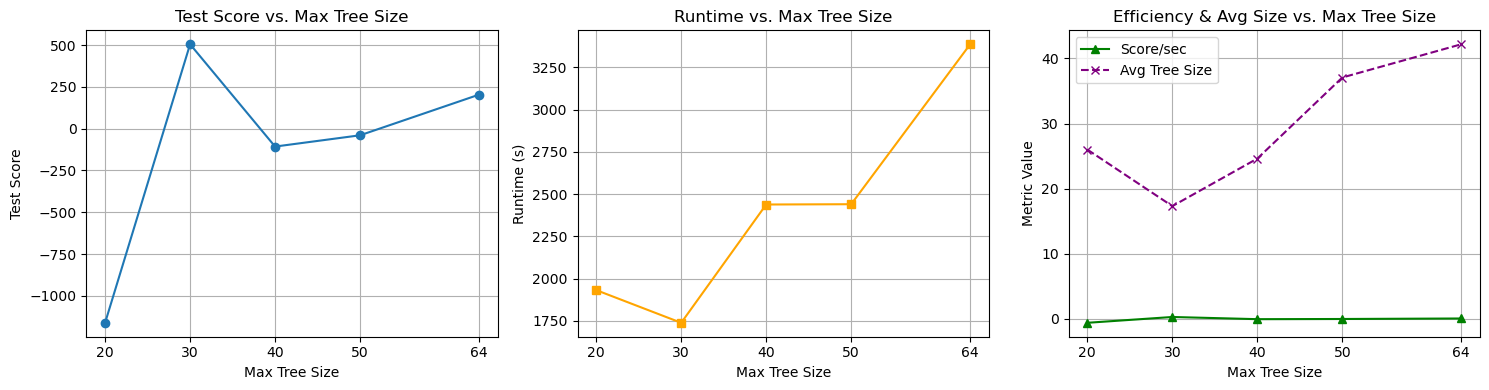

In [11]:
def average_tree_size(population):
    total_nodes = 0
    total_trees = 0
    for individual in population:
        for tree in individual.children:
            total_nodes += len(tree.get_subtree())
            total_trees += 1
    return total_nodes / total_trees if total_trees > 0 else 0.0

def finetune_tree_size(tree_sizes, repeats=3, early_stop_patience=5):
    results = []

    for max_tree_size in tree_sizes:
        print(f"\n Testing max_tree_size = {max_tree_size}")
        run_scores, run_times, run_avg_sizes = [], [], []

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=max_tree_size,
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            best = evo.best_of_gens[-1]
            score = get_test_score(best)
            avg_size = average_tree_size(evo.population)
            
            run_scores.append(score)
            run_times.append(elapsed)
            run_avg_sizes.append(avg_size)

        avg_score = np.mean(run_scores)
        avg_time = np.mean(run_times)
        avg_avg_size = np.mean(run_avg_sizes)
        efficiency = avg_score / avg_time if avg_time > 0 else 0

        print(f" Tree size {max_tree_size}: Score = {avg_score:.2f}, Time = {avg_time:.1f}s, Avg Tree Size = {avg_avg_size:.1f}")
        results.append((max_tree_size, avg_score, avg_time, efficiency, avg_avg_size))

    return results

def save_results_to_csv(results, folder="log/max_tree_size"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    csv_path = os.path.join(folder, f"{timestamp}.csv")
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Max Tree Size", "Test Score", "Runtime (s)", "Score/sec", "Avg Tree Size"])
        writer.writerows(results)
    return timestamp

def plot_tree_size_tuning(results, folder="log/max_tree_size", timestamp=None):
    sizes, scores, times, effs, avg_sizes = zip(*results)
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(sizes, scores, marker='o')
    plt.title("Test Score vs. Max Tree Size")
    plt.xlabel("Max Tree Size")
    plt.ylabel("Test Score")
    plt.grid(True)
    plt.xticks(sizes)

    plt.subplot(1, 3, 2)
    plt.plot(sizes, times, marker='s', color='orange')
    plt.title("Runtime vs. Max Tree Size")
    plt.xlabel("Max Tree Size")
    plt.ylabel("Runtime (s)")
    plt.grid(True)
    plt.xticks(sizes)

    plt.subplot(1, 3, 3)
    plt.plot(sizes, effs, marker='^', color='green', label="Score/sec")
    plt.plot(sizes, avg_sizes, marker='x', linestyle='--', color='purple', label="Avg Tree Size")
    plt.title("Efficiency & Avg Size vs. Max Tree Size")
    plt.xlabel("Max Tree Size")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.xticks(sizes)

    plt.tight_layout()
    if timestamp:
        png_path = os.path.join(folder, f"{timestamp}.png")
        plt.savefig(png_path)

    plt.show()


tree_sizes = [20, 30, 40, 50, 64]
results = finetune_tree_size(tree_sizes, repeats=3, early_stop_patience=5)
timestamp = save_results_to_csv(results)
plot_tree_size_tuning(results, timestamp=timestamp)

### Variation & Selection Parameters


 Testing crossover probability = 0.9, mutation probability = 0.1, tournament size = 4
 Avg Score: -681.73, Time: 1249.8s, Efficiency: -0.545

 Testing crossover probability = 0.85, mutation probability = 0.15, tournament size = 4
 Avg Score: 264.63, Time: 1179.3s, Efficiency: 0.224

 Testing crossover probability = 0.95, mutation probability = 0.05, tournament size = 4
 Avg Score: -99.33, Time: 970.3s, Efficiency: -0.102


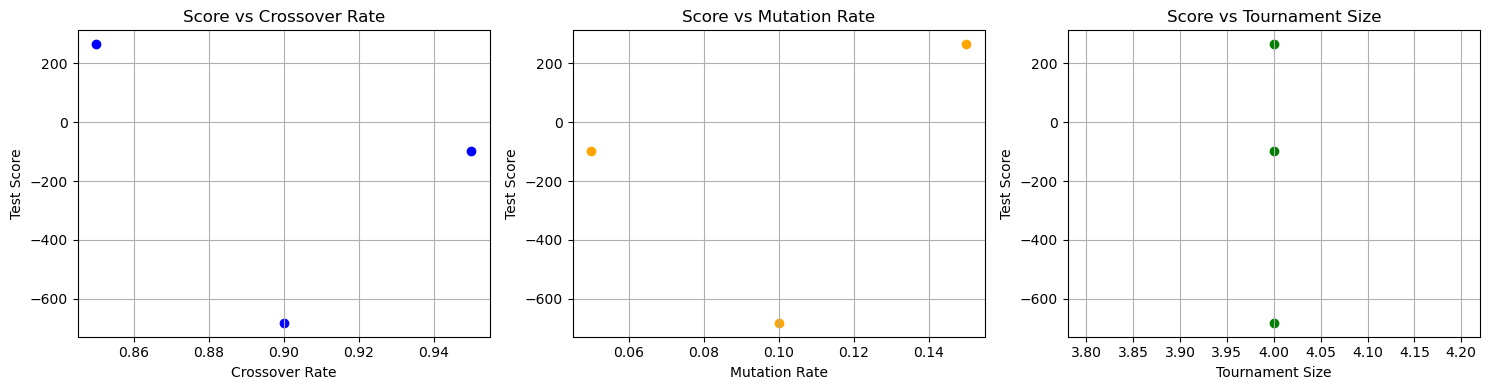

In [18]:
from genepro.variation import subtree_crossover, subtree_mutation
from genepro.selection import tournament_selection

def finetune_variation_selection(configs, repeats=3, early_stop_patience=5):
    results = []

    for cfg in configs:
        all_scores, all_times = [], []

        print(f"\n Testing crossover probability = {cfg['crossover']}, mutation probability = {cfg['mutation']}, tournament size = {cfg['tournament']}")

        for run in range(repeats):
            start_time = time.time()

            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": cfg["crossover"]}],
                mutations =[{"fun": subtree_mutation, "rate": cfg["mutation"]}],
                selection={"fun": tournament_selection, "kwargs": {"tournament_size": cfg["tournament"]}},
                n_jobs=10,
                verbose=False
            )
            
            # Early stopping
            evo._initialize_population()
            no_improve = 0
            best_fitness = evo.best_of_gens[-1].fitness
    
            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
    
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
    
                if early_stop_patience is not None and no_improve >= early_stop_patience:
                    if evo.verbose:
                        print(f" Early stopping at gen {evo.num_gens}, no improvement in {early_stop_patience} gens")
                    break
                    
            elapsed = time.time() - start_time
            best = evo.best_of_gens[-1]
            score = get_test_score(best)
            all_scores.append(score)
            all_times.append(elapsed)

        mean_score = np.mean(all_scores)
        mean_time = np.mean(all_times)
        efficiency = mean_score / mean_time if mean_time > 0 else 0

        print(f" Avg Score: {mean_score:.2f}, Time: {mean_time:.1f}s, Efficiency: {efficiency:.3f}")
        results.append((cfg["crossover"], cfg["mutation"], cfg["tournament"], mean_score, mean_time, efficiency))

    return results

def save_variation_results_csv(results, folder="log/variation_tuning"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")
    with open(path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Crossover", "Mutation", "Tournament", "Test Score", "Runtime (s)", "Score/sec"])
        writer.writerows(results)
    return timestamp

def plot_variation_tuning(results, folder="log/variation_tuning", timestamp=None):
    crossover, mutation, tournament, score, runtime, eff = zip(*results)

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    
    axs[0].scatter(crossover, score, color='blue')
    axs[0].set_title("Score vs Crossover Rate")
    axs[0].set_xlabel("Crossover Rate")
    axs[0].set_ylabel("Test Score")
    axs[0].grid(True)

    axs[1].scatter(mutation, score, color='orange')
    axs[1].set_title("Score vs Mutation Rate")
    axs[1].set_xlabel("Mutation Rate")
    axs[1].set_ylabel("Test Score")
    axs[1].grid(True)

    axs[2].scatter(tournament, score, color='green')
    axs[2].set_title("Score vs Tournament Size")
    axs[2].set_xlabel("Tournament Size")
    axs[2].set_ylabel("Test Score")
    axs[2].grid(True)

    plt.tight_layout()
    if timestamp:
        os.makedirs(folder, exist_ok=True)
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()


configs = [
    {"crossover": 0.9, "mutation": 0.1, "tournament": 4},
    {"crossover": 0.85, "mutation": 0.15, "tournament": 4},
    {"crossover": 0.95, "mutation": 0.05, "tournament": 4},
]
results = finetune_variation_selection(configs)
timestamp = save_variation_results_csv(results)
plot_variation_tuning(results, timestamp=timestamp)

### Coefficient Optimization

In [22]:
def finetune_coeff_opts(rates, ranges, enable_opts, repeats=3, early_stop_patience=5):
    results = []
    
    for enabled in enable_opts:
        for c_range in ranges:
            Constant().range = c_range
            for rate in rates:
                coeff_config = [{"fun": coeff_mutation, "rate": rate}] if enabled else []

                scores, times = [], []
                print(f"\n Testing: rate = {rate}, range = {c_range}, enabled = {enabled}")

                for _ in range(repeats):
                    start_time = time.time()
                    evo = Evolution(
                        fitness_function=fitness_function_pt,
                        internal_nodes=internal_nodes,
                        leaf_nodes=leaf_nodes,
                        n_trees=4,
                        pop_size=128,
                        max_gens=30,
                        max_tree_size=30,
                        crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                        mutations=[{"fun": subtree_mutation, "rate": 0.15}],
                        coeff_opts=coeff_config,
                        selection={"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
                        n_jobs=10,
                        verbose=False
                    )

                    evo._initialize_population()
                    best_fitness = evo.best_of_gens[-1].fitness
                    no_improve = 0

                    for _ in range(evo.max_gens):
                        evo._perform_generation()
                        current_fitness = evo.best_of_gens[-1].fitness
                        if current_fitness > best_fitness:
                            best_fitness = current_fitness
                            no_improve = 0
                        else:
                            no_improve += 1
                        if no_improve >= early_stop_patience:
                            break

                    elapsed = time.time() - start_time
                    score = get_test_score(evo.best_of_gens[-1])
                    scores.append(score)
                    times.append(elapsed)
                    
                avg_score = np.mean(scores)
                avg_time = np.mean(times)
                efficiency = avg_score / avg_time if avg_time > 0 else 0
                results.append((enabled, str(c_range), rate, "-", avg_score, avg_time, efficiency))

    return results

def save_coeff_results_csv(results, folder="log/coeff_tuning"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")
    with open(path, mode="w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Enabled", "Range", "Coeff Rate", "Sigma", "Test Score", "Runtime (s)", "Score/sec"])
        writer.writerows(results)
    return timestamp

def plot_coeff_tuning(results, folder="log/coeff_tuning", timestamp=None):
    data = np.array(results, dtype=object)
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    for enabled in [True, False]:
        mask = data[:,0] == enabled
        scores = data[mask, 4].astype(float)
        effs = data[mask, 6].astype(float)
        labels = [f"{data[i,2]}|{data[i,3]}" for i in range(len(data)) if mask[i]]

        axs[0].plot(labels, scores, marker='o', label=f"Enabled={enabled}")
        axs[1].plot(labels, effs, marker='s', label=f"Enabled={enabled}")

    axs[0].set_title("Test Score vs. Coeff Config")
    axs[0].set_ylabel("Test Score")
    axs[1].set_title("Score/sec vs. Coeff Config")
    axs[1].set_ylabel("Efficiency (Score/sec)")
    for ax in axs:
        ax.set_xlabel("Rate|Sigma")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)
        ax.legend()
    plt.tight_layout()

    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()


rates = [0.1, 0.3, 0.5, 0.7, 1.0]
ranges = [(-1, 1), (-5, 5), (-10, 10)]
enable_opts = [True, False]
results = finetune_coeff_opts(rates, ranges, enable_opts, repeats=3, early_stop_patience=5)
timestamp = save_coeff_results_csv(results)
plot_coeff_tuning(results, timestamp=timestamp)


 Testing: rate = 0.1, range = (-1, 1), enabled = True


KeyboardInterrupt: 

### Internal Node Types 

In [ ]:
from genepro.variation import subtree_crossover, subtree_mutation, coeff_mutation
from genepro.selection import tournament_selection
from genepro.node_impl import Plus, Minus, Times, Divide, Sin, Cos

def finetune_internal_nodes(configs, repeats=3, early_stop_patience=5):
    results = []

    for cfg in configs:
        label = '+'.join([node.__class__.__name__ for node in cfg])
        print(f"\n Testing internal nodes: {label}")

        scores, times = [], []

        for _ in range(repeats):
            start_time = time.time()
            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=cfg,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                mutations=[{"fun": subtree_mutation, "rate": 0.15}],
                coeff_opts=[{"fun": coeff_mutation, "rate": 0.3}],
                selection={"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness

                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve >= early_stop_patience:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            scores.append(score)
            times.append(elapsed)

        avg_score = np.mean(scores)
        avg_time = np.mean(times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0
        results.append((label, avg_score, avg_time, efficiency))

    return results

def save_internal_nodes_csv(results, folder="log/internal_nodes"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = os.path.join(folder, f"{timestamp}.csv")

    with open(path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Internal Nodes", "Test Score", "Runtime (s)", "Score/sec"])
        writer.writerows(results)

    return timestamp

def plot_internal_nodes(results, folder="log/internal_nodes", timestamp=None):
    labels, scores, times, effs = zip(*results)

    x = np.arange(len(labels))
    width = 0.3

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.bar(x - width/2, scores, width, label="Test Score")
    plt.bar(x + width/2, effs, width, label="Score/sec")
    plt.xticks(x, labels, rotation=45)
    plt.title("Performance by Internal Node Set")
    plt.xlabel("Internal Node Set")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.bar(x, times, color='orange')
    plt.xticks(x, labels, rotation=45)
    plt.title("Runtime by Internal Node Set")
    plt.xlabel("Internal Node Set")
    plt.ylabel("Runtime (s)")
    plt.grid(True)

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()


configs = [
    [Plus(), Minus()],
    [Plus(), Minus(), Times()],
    [Plus(), Minus(), Times(), Divide()],
    [Plus(), Minus(), Times(), Divide(), Sin()],
    [Plus(), Minus(), Times(), Divide(), Sin(), Cos()]
]

results = finetune_internal_nodes(configs, repeats=3, early_stop_patience=5)
timestamp = save_internal_nodes_csv(results)
plot_internal_nodes(results, timestamp=timestamp)


### Constant Probability

In [ ]:
from genepro.variation import subtree_crossover, subtree_mutation, coeff_mutation
from genepro.selection import tournament_selection
from genepro.node_impl import Constant

# Assumes generate_random_multitree uses a global or passed-in constant_prob

def finetune_constant_prob(probs, repeats=3):
    results = []

    for prob in probs:
        print(f"\n Testing constant probability = {prob}")
        scores, times = [], []

        for _ in range(repeats):
            start_time = time.time()

            # Set probability globally or pass into initializer if supported
            Constant.prob = prob  # <- make sure your node uses this correctly

            evo = Evolution(
                fitness_function=fitness_function_pt,
                internal_nodes=internal_nodes,
                leaf_nodes=leaf_nodes,
                n_trees=4,
                pop_size=128,
                max_gens=30,
                max_tree_size=30,
                crossovers=[{"fun": subtree_crossover, "rate": 0.85}],
                mutations =[{"fun": subtree_mutation, "rate": 0.15}],
                coeff_opts=[{"fun": coeff_mutation, "rate": 0.3}],
                selection={"fun": tournament_selection, "kwargs": {"tournament_size": 4}},
                n_jobs=10,
                verbose=False
            )

            evo._initialize_population()
            best_fitness = evo.best_of_gens[-1].fitness
            no_improve = 0

            for _ in range(evo.max_gens):
                evo._perform_generation()
                current_fitness = evo.best_of_gens[-1].fitness
                if current_fitness > best_fitness:
                    best_fitness = current_fitness
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= 5:
                    break

            elapsed = time.time() - start_time
            score = get_test_score(evo.best_of_gens[-1])
            scores.append(score)
            times.append(elapsed)

        avg_score = np.mean(scores)
        avg_time = np.mean(times)
        efficiency = avg_score / avg_time if avg_time > 0 else 0
        results.append((prob, avg_score, avg_time, efficiency))

    return results

def save_constant_prob_results(results, folder="log/const_prob"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    csv_path = os.path.join(folder, f"{timestamp}.csv")
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Constant Prob", "Test Score", "Runtime (s)", "Score/sec"])
        writer.writerows(results)
    return timestamp

def plot_constant_prob(results, folder="log/const_prob", timestamp=None):
    probs, scores, times, effs = zip(*results)
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.plot(probs, scores, marker='o')
    plt.title("Test Score vs. Constant Probability")
    plt.xlabel("Constant Probability")
    plt.ylabel("Test Score")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(probs, times, marker='s', color='orange')
    plt.title("Runtime vs. Constant Probability")
    plt.xlabel("Constant Probability")
    plt.ylabel("Runtime (s)")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(probs, effs, marker='^', color='green')
    plt.title("Score/sec vs. Constant Probability")
    plt.xlabel("Constant Probability")
    plt.ylabel("Score/sec")
    plt.grid(True)

    plt.tight_layout()
    if timestamp:
        plt.savefig(os.path.join(folder, f"{timestamp}.png"))
    plt.show()

probs = [0.1, 0.25, 0.5, 0.75, 0.9]
results = finetune_constant_prob(probs)
timestamp = save_constant_prob_results(results)
plot_constant_prob(results, timestamp=timestamp)

## Make an animation
Here the best evolved individual is selected and one episode is rendered. Make sure to save your lunar landers over time to track progress and make comparisons.

In [ ]:
frames = []

# gist to save gif from https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
def save_frames_as_gif(frames, path='./', filename='evolved_lander.gif'):
  plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
  patch = plt.imshow(frames[0])
  plt.axis('off')
  def animate(i):
      patch.set_data(frames[i])
  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
  anim.save(path + filename, writer='imagemagick', fps=60)

frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames)

## Play animation

<img src="evolved_lander.gif" width="750">

## Optimisation
The coefficients in the multi-tree aren't optimised. Here Q-learning (taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) is used to optimise the weights further. Incorporate coefficient optimisation in training your agent(s). Coefficient Optimisation can be expensive. Think about how often you want to optimise, when, which individuals etc.

In [ ]:
batch_size = 128
GAMMA = 0.99

constants = best.get_subtrees_consts()

if len(constants)>0:
  optimizer = optim.AdamW(constants, lr=1e-3, amsgrad=True)

for _ in range(500):

  if len(constants)>0 and len(evo.memory)>batch_size:
    target_tree = copy.deepcopy(best)

    transitions = evo.memory.sample(batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                        batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                               if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = best.get_output_pt(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, dtype=torch.float)
    with torch.no_grad():
      next_state_values[non_final_mask] = target_tree.get_output_pt(non_final_next_states).max(1)[0].float()

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
   
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(constants, 100)
    optimizer.step()

print(best.get_readable_repr())
print(get_test_score(best))

In [ ]:
frames = []
fitness_function_pt(best, num_episodes=1, episode_duration=500, render=True, ignore_done=False)
env.close()
save_frames_as_gif(frames, filename='evolved_lander_RL.gif')

<img src="evolved_lander_RL.gif" width="750">